🔄 Fetching data until 2025-08-26 16:09


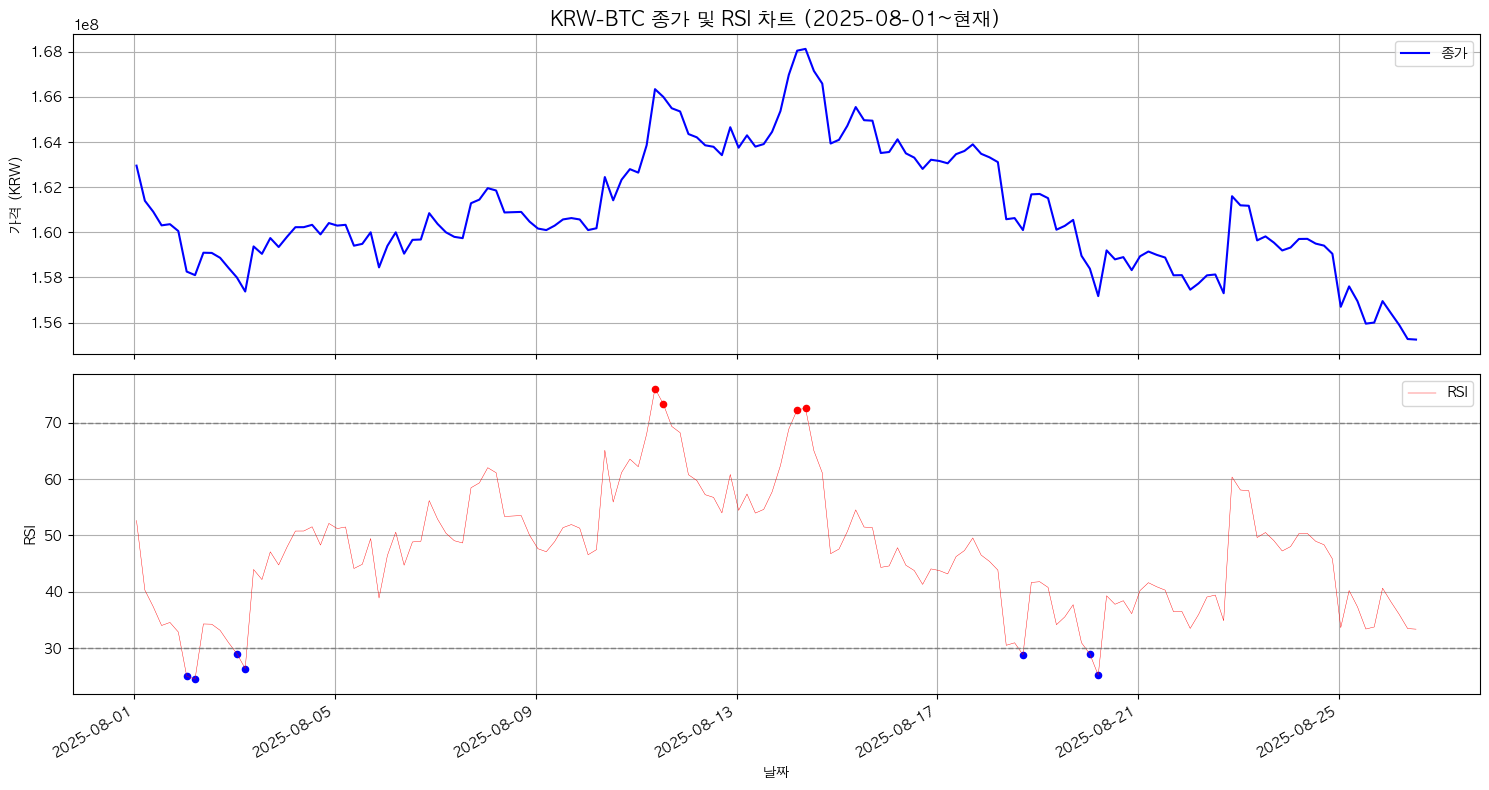


============== RSI 백테스트 결과 ==============
📅 기간: 2025-08-01 ~ 2025-08-26
💼 초기 자본: 1,000,000원
💰 최종 자산: 1,019,125원
📈 총 수익률: 1.91%
🤖 봇 실행 간격: 30분마다
🕒 캔들 간격: 240분
🔁 캔들 수: 154개
🧠 총 봇 실행 횟수: 1,232회
============== 거래 내역 ==============
[2025-08-02 01:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.001263 | 총 매수가격: 200,000 | 남은 자본: 800,000원
[2025-08-02 01:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.001010 | 총 매수가격: 160,000 | 남은 자본: 640,000원
[2025-08-02 02:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000808 | 총 매수가격: 128,000 | 남은 자본: 512,000원
[2025-08-02 02:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000647 | 총 매수가격: 102,400 | 남은 자본: 409,600원
[2025-08-02 03:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000517 | 총 매수가격: 81,920 | 남은 자본: 327,680원
[2025-08-02 03:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000414 | 총 매수가격: 65,536 | 남은 자본: 262,144원
[2025-08-02 04:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000331 | 총 매수가격: 52,429 | 남은 자본: 209,715원
[2025-08-02 04:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000265 | 총 매수가격: 41,943 | 남은 자본: 167,772원
[2025-08-02 05:00] 🟦 매수 | 가격: 15

In [68]:
import pyupbit                          # 업비트 시세 데이터 API
import matplotlib as mpl               # 폰트 설정 등
import matplotlib.pyplot as plt        # 시각화 라이브러리
import pandas as pd                    # 데이터 처리용
from datetime import datetime, timedelta   # 날짜 계산용
import matplotlib.dates as mdates      # 날짜 포맷 설정용

# 한글 폰트 및 마이너스 깨짐 방지 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

########## 설정 값 ##########
ticker = "KRW-BTC"                     # 조회할 마켓 (예: 비트코인/원화)
start_date = "2025-08-01"              # 데이터 조회 시작일
interval = "minute240"                 # 캔들 간격 (1시간봉)
rsi_period = 14                        # RSI 기간
bot_interval = 30                      # 30분 간격으로 실행(1시간에 2번 실행, 240분봉이면 2 * 4 = 8번동안 같은 매수/매도) 
initial_capital = 1_000_000            # 초기 자본
min_trade = 5000                       # 최소 거래 금액
fee = 0.0005                           # 수수료 (0.05%)
############################


####################################### 데이터 수집 #######################################
# RSI를 위해 시작일보다 앞 데이터를 더 확보
extra_hours = rsi_period * 2    # 최소 rsi_period개 이상 확보하기 위한 여유
real_start = pd.to_datetime(start_date) - timedelta(hours=extra_hours)

to = datetime.now()                    # 현재 시간부터 시작
all_data = []                          # 데이터를 저장할 리스트

# 🔁 200개 단위로 반복해서 과거 데이터 수집
while True:
    data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=200)
    print(f"🔄 Fetching data until {to.strftime('%Y-%m-%d %H:%M')}")

    if data is None or data.empty:
        break

    all_data.append(data)
    to = data.index[0]

    if to < real_start:
        break

# 📦 수집한 데이터 병합 및 정리
df = pd.concat(all_data)
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()


######################################## RSI 계산 ########################################
def compute_rsi(data, period=14):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)

    ma_up = up.ewm(com=period - 1, min_periods=period).mean()
    ma_down = down.ewm(com=period - 1, min_periods=period).mean()
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI"] = compute_rsi(df["close"], rsi_period)

# ✅ start_date 이후 데이터만 사용
df = df[df.index >= pd.to_datetime(start_date)]


###################################### 📊 그래프 출력 ######################################
# 📊 그래프 그리기
plt.figure(figsize=(15, 8))

# 🟦 종가 차트 
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df.index, df["close"], label="종가", color='blue')
ax1.set_title(f"{ticker} 종가 및 RSI 차트 ({start_date}~현재)", fontsize=14)
ax1.set_ylabel("가격 (KRW)")
ax1.grid(True)
ax1.legend()

# 🟨 RSI 차트
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(df.index, df["RSI"], label="RSI", color='red', linewidth=0.3)
ax2.axhline(70, color='gray', linestyle='--', linewidth=1)
ax2.axhline(30, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("RSI")
ax2.set_xlabel("날짜")
ax2.grid(True)
ax2.legend()

# 🔴 RSI ≥ 70 표시
rsi_overbought = df[df["RSI"] >= 70]
ax2.scatter(rsi_overbought.index, rsi_overbought["RSI"], color='red', s=20, label='RSI ≥ 70')

# 🔵 RSI ≤ 30 표시
rsi_oversold = df[df["RSI"] <= 30]
ax2.scatter(rsi_oversold.index, rsi_oversold["RSI"], color='blue', s=20, label='RSI ≤ 30')

# ✅ 날짜 포맷 자동 회전
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
#########################################################################################

##############################################
# 💰 RSI 백테스트 시뮬레이션 (봇 실행 간격 반영)
##############################################
capital = initial_capital
position = 0
avg_buy_price = 0
trade_log = []

minutes_per_candle = int(interval.replace("minute", ""))
runs_per_candle = minutes_per_candle // bot_interval  # 예: 240 / 30 = 8

for i in range(1, len(df)):
    rsi = df["RSI"].iloc[i]
    price = df["close"].iloc[i]
    time = df.index[i]

    # ⏱️ 해당 4시간봉 내에서 봇이 여러 번 실행되었다고 가정
    for j in range(runs_per_candle):
        exec_time = time + timedelta(minutes=bot_interval * j)

        # 📉 매수 조건 (조건만 맞으면 매번 매수)
        if rsi <= 30 and capital > min_trade:
            invest = capital * 0.2
            if invest >= min_trade:
                qty = (invest * (1 - fee)) / price
                position += qty
                capital -= invest
                trade_log.append((exec_time, "BUY", price, qty, capital))

        # 📈 매도 조건 (조건만 맞으면 매번 매도)
        elif rsi >= 70 and position > 0:
            proceeds = position * price * (1 - fee)
            capital += proceeds
            trade_log.append((exec_time, "SELL", price, position, capital))
            position = 0

final_value = capital + position * df["close"].iloc[-1]
roi = (final_value - initial_capital) / initial_capital * 100


# 결과 출력
print("\n============== RSI 백테스트 결과 ==============")
print(f"📅 기간: {start_date} ~ {df.index[-1].strftime('%Y-%m-%d')}")
print(f"💼 초기 자본: {initial_capital:,.0f}원")
print(f"💰 최종 자산: {final_value:,.0f}원")
print(f"📈 총 수익률: {roi:.2f}%")
print("===============================================")
# 봇 실행 횟수 계산
minutes_per_candle = int(interval.replace("minute", ""))
runs_per_candle = minutes_per_candle // bot_interval
total_candles = len(df)
bot_runs = total_candles * runs_per_candle
print(f"🤖 봇 실행 간격: {bot_interval}분마다")
print(f"🕒 캔들 간격: {minutes_per_candle}분")
print(f"🔁 캔들 수: {total_candles}개")
print(f"🧠 총 봇 실행 횟수: {bot_runs:,}회")


# 📜 거래 내역 출력
print("============== 거래 내역 ==============")
current_hold = 0
buy_price = 0
total_spent = 0

for log in trade_log:
    time, action, price, qty, cash = log

    if action == "BUY":
        total_spent = price * qty * (1 + fee)  # 수수료 포함 매수가격
        buy_price = price
        current_hold = qty
        print(
            f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟦 매수 | "
            f"가격: {price:,.0f} | 수량: {qty:.6f} | 총 매수가격: {total_spent:,.0f} | "
            f"남은 자본: {cash:,.0f}원"
        )

    elif action == "SELL":
        proceeds = price * qty * (1 - fee)
        gain = proceeds - total_spent
        cash += proceeds  # ← 매도해서 자본 증가
        print(
            f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟥 매도 | "
            f"가격: {price:,.0f} | 수량: {qty:.6f} | 실현 금액: {proceeds:,.0f} | "
            f"남은 자본: {cash:,.0f}원"
        )
        print(
            f"              ➜ 💸 추정 수익: {gain:,.0f}원 (매수가격: {total_spent:,.0f})"
        )

print("========================================\n")


with open("trade_log.txt", "w", encoding="utf-8") as f:
    f.write("============== 거래 내역 ==============\n")
    current_hold = 0
    buy_price = 0
    total_spent = 0

    for log in trade_log:
        time, action, price, qty, cash = log

        if action == "BUY":
            total_spent = price * qty * (1 + fee)  # 수수료 포함 매수가격
            buy_price = price
            current_hold = qty
            f.write(
                f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟦 매수 | "
                f"가격: {price:,.0f} | 수량: {qty:.6f} | 총 매수가격: {total_spent:,.0f} | "
                f"남은 자본: {cash:,.0f}원\n"
            )

        elif action == "SELL":
            proceeds = price * qty * (1 - fee)
            gain = proceeds - total_spent
            cash += proceeds  # ← 매도해서 자본 증가
            f.write(
                f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟥 매도 | "
                f"가격: {price:,.0f} | 수량: {qty:.6f} | 실현 금액: {proceeds:,.0f} | "
                f"남은 자본: {cash:,.0f}원\n"
            )
            f.write(
                f"              ➜ 💸 추정 수익: {gain:,.0f}원 (매수가격: {total_spent:,.0f})\n"
            )

    f.write("========================================\n")




## End Date 수정 가능버전

🔄 Fetching data until 2025-08-27 00:00


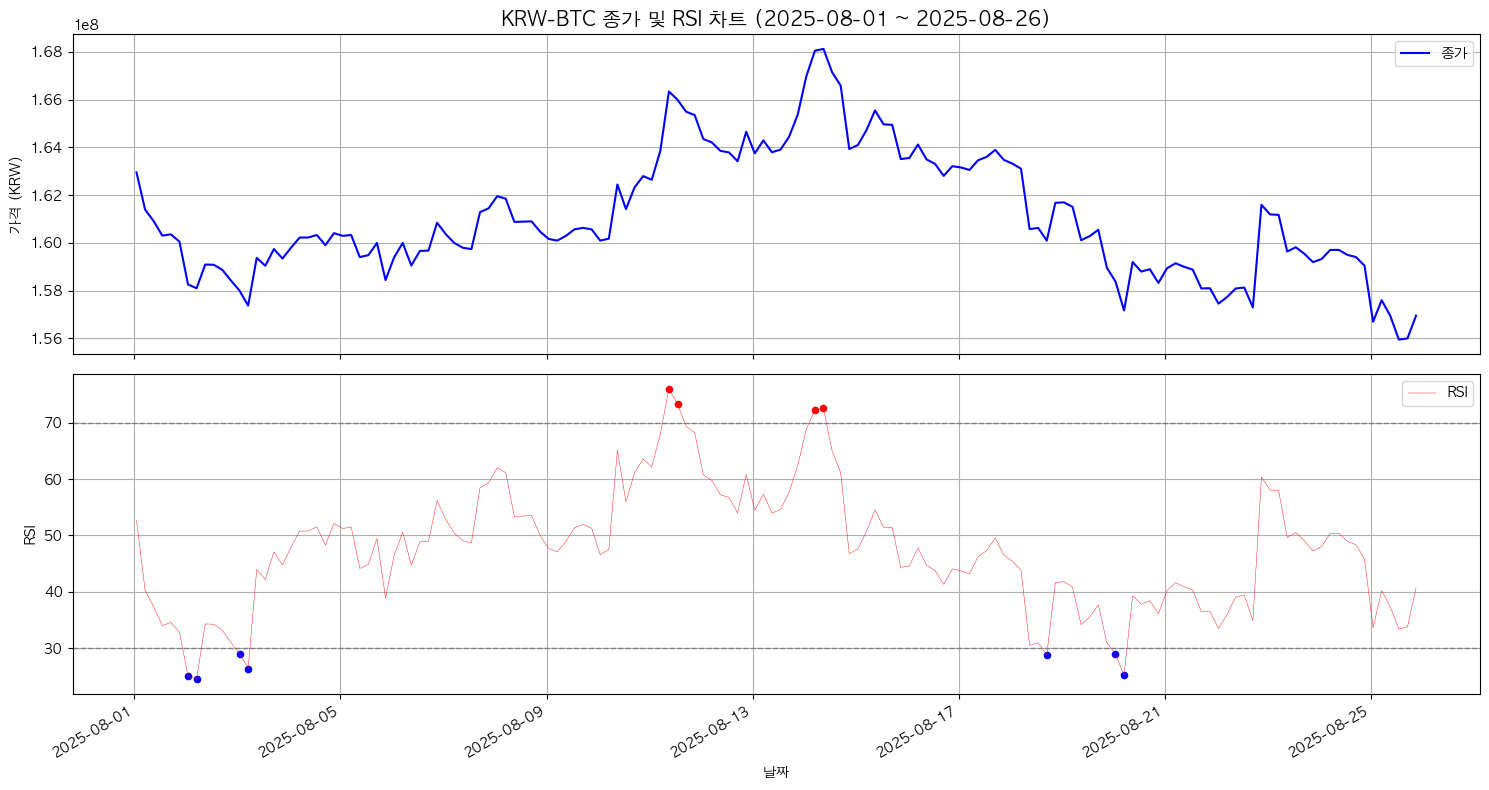


============== RSI 백테스트 결과 ==============
📅 기간: 2025-08-01 ~ 2025-08-26
💼 초기 자본: 1,000,000원
💰 최종 자산: 1,030,058원
📈 총 수익률: 3.01%
🤖 봇 실행 간격: 30분마다
🕒 캔들 간격: 240분
🔁 캔들 수: 150개
🧠 총 봇 실행 횟수: 1,200회
============== 거래 내역 ==============
[2025-08-02 01:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.001263 | 총 매수가격: 200,000 | 남은 자본: 800,000원
[2025-08-02 01:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.001010 | 총 매수가격: 160,000 | 남은 자본: 640,000원
[2025-08-02 02:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000808 | 총 매수가격: 128,000 | 남은 자본: 512,000원
[2025-08-02 02:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000647 | 총 매수가격: 102,400 | 남은 자본: 409,600원
[2025-08-02 03:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000517 | 총 매수가격: 81,920 | 남은 자본: 327,680원
[2025-08-02 03:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000414 | 총 매수가격: 65,536 | 남은 자본: 262,144원
[2025-08-02 04:00] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000331 | 총 매수가격: 52,429 | 남은 자본: 209,715원
[2025-08-02 04:30] 🟦 매수 | 가격: 158,260,000 | 수량: 0.000265 | 총 매수가격: 41,943 | 남은 자본: 167,772원
[2025-08-02 05:00] 🟦 매수 | 가격: 15

In [73]:
import pyupbit                          # 업비트 시세 데이터 API
import matplotlib as mpl               # 폰트 설정 등
import matplotlib.pyplot as plt        # 시각화 라이브러리
import pandas as pd                    # 데이터 처리용
from datetime import datetime, timedelta   # 날짜 계산용
import matplotlib.dates as mdates      # 날짜 포맷 설정용

# 한글 폰트 및 마이너스 깨짐 방지 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

########## 설정 값 ##########
ticker = "KRW-BTC"                     # 조회할 마켓 (예: 비트코인/원화)
start_date = "2025-08-01"              # 데이터 조회 시작일
end_date = "2025-08-26"                # 데이터 조회 종료일 (포함)
interval = "minute240"                 # 캔들 간격 (240분봉)
rsi_period = 14                        # RSI 기간
bot_interval = 30                      # 30분 간격으로 실행 (240분봉이면 8번)
initial_capital = 1_000_000            # 초기 자본
min_trade = 5000                       # 최소 거래 금액
fee = 0.0005                           # 수수료 (0.05%)
############################


####################################### 데이터 수집 #######################################
# RSI를 위해 시작일보다 앞 데이터를 더 확보
extra_hours = rsi_period * 2    # 최소 rsi_period개 이상 확보하기 위한 여유
real_start = pd.to_datetime(start_date) - timedelta(hours=extra_hours)
to = pd.to_datetime(end_date) + timedelta(days=1)  # 종료일 다음날까지 수집
all_data = []                          # 데이터를 저장할 리스트

# 🔁 200개 단위로 반복해서 과거 데이터 수집
while True:
    data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=200)
    print(f"🔄 Fetching data until {to.strftime('%Y-%m-%d %H:%M')}")

    if data is None or data.empty:
        break

    all_data.append(data)
    to = data.index[0]

    if to < real_start:
        break

# 📦 수집한 데이터 병합 및 정리
df = pd.concat(all_data)
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()


######################################## RSI 계산 ########################################
def compute_rsi(data, period=14):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)

    ma_up = up.ewm(com=period - 1, min_periods=period).mean()
    ma_down = down.ewm(com=period - 1, min_periods=period).mean()
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI"] = compute_rsi(df["close"], rsi_period)

# ✅ start_date ~ end_date 범위의 데이터만 사용
df = df[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]


###################################### 📊 그래프 출력 ######################################
# 📊 그래프 그리기
plt.figure(figsize=(15, 8))

# 🟦 종가 차트 
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df.index, df["close"], label="종가", color='blue')
ax1.set_title(f"{ticker} 종가 및 RSI 차트 ({start_date} ~ {end_date})", fontsize=14)
ax1.set_ylabel("가격 (KRW)")
ax1.grid(True)
ax1.legend()

# 🟨 RSI 차트
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(df.index, df["RSI"], label="RSI", color='red', linewidth=0.3)
ax2.axhline(70, color='gray', linestyle='--', linewidth=1)
ax2.axhline(30, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("RSI")
ax2.set_xlabel("날짜")
ax2.grid(True)
ax2.legend()

# 🔴 RSI ≥ 70 표시
rsi_overbought = df[df["RSI"] >= 70]
ax2.scatter(rsi_overbought.index, rsi_overbought["RSI"], color='red', s=20, label='RSI ≥ 70')

# 🔵 RSI ≤ 30 표시
rsi_oversold = df[df["RSI"] <= 30]
ax2.scatter(rsi_oversold.index, rsi_oversold["RSI"], color='blue', s=20, label='RSI ≤ 30')

# ✅ 날짜 포맷 자동 회전
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
#########################################################################################

##############################################
# 💰 RSI 백테스트 시뮬레이션 (봇 실행 간격 반영)
##############################################
capital = initial_capital
position = 0
avg_buy_price = 0
trade_log = []

minutes_per_candle = int(interval.replace("minute", ""))
runs_per_candle = minutes_per_candle // bot_interval  # 예: 240 / 30 = 8

for i in range(1, len(df)):
    rsi = df["RSI"].iloc[i]
    price = df["close"].iloc[i]
    time = df.index[i]

    # ⏱️ 해당 4시간봉 내에서 봇이 여러 번 실행되었다고 가정
    for j in range(runs_per_candle):
        exec_time = time + timedelta(minutes=bot_interval * j)

        # 📉 매수 조건 (조건만 맞으면 매번 매수)
        if rsi <= 30 and capital > min_trade:
            invest = capital * 0.2
            if invest >= min_trade:
                qty = (invest * (1 - fee)) / price
                position += qty
                capital -= invest
                trade_log.append((exec_time, "BUY", price, qty, capital))

        # 📈 매도 조건 (조건만 맞으면 매번 매도)
        elif rsi >= 70 and position > 0:
            proceeds = position * price * (1 - fee)
            capital += proceeds
            trade_log.append((exec_time, "SELL", price, position, capital))
            position = 0

final_value = capital + position * df["close"].iloc[-1]
roi = (final_value - initial_capital) / initial_capital * 100


# 결과 출력
print("\n============== RSI 백테스트 결과 ==============")
print(f"📅 기간: {start_date} ~ {end_date}")
print(f"💼 초기 자본: {initial_capital:,.0f}원")
print(f"💰 최종 자산: {final_value:,.0f}원")
print(f"📈 총 수익률: {roi:.2f}%")
print("==============================================")
# 봇 실행 횟수 계산
minutes_per_candle = int(interval.replace("minute", ""))
runs_per_candle = minutes_per_candle // bot_interval
total_candles = len(df)
bot_runs = total_candles * runs_per_candle
print(f"🤖 봇 실행 간격: {bot_interval}분마다")
print(f"🕒 캔들 간격: {minutes_per_candle}분")
print(f"🔁 캔들 수: {total_candles}개")
print(f"🧠 총 봇 실행 횟수: {bot_runs:,}회")


# 📜 거래 내역 출력
print("============== 거래 내역 ==============")
current_hold = 0
buy_price = 0
total_spent = 0

for log in trade_log:
    time, action, price, qty, cash = log

    if action == "BUY":
        total_spent = price * qty * (1 + fee)
        buy_price = price
        current_hold = qty
        print(
            f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟦 매수 | "
            f"가격: {price:,.0f} | 수량: {qty:.6f} | 총 매수가격: {total_spent:,.0f} | "
            f"남은 자본: {cash:,.0f}원"
        )

    elif action == "SELL":
        proceeds = price * qty * (1 - fee)
        gain = proceeds - total_spent
        cash += proceeds
        print(
            f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟥 매도 | "
            f"가격: {price:,.0f} | 수량: {qty:.6f} | 실현 금액: {proceeds:,.0f} | "
            f"남은 자본: {cash:,.0f}원"
        )
        print(
            f"              ➜ 💸 추정 수익: {gain:,.0f}원 (매수가격: {total_spent:,.0f})"
        )

print("========================================\n")


with open("trade_log.txt", "w", encoding="utf-8") as f:
    f.write("============== 거래 내역 ==============\n")
    current_hold = 0
    buy_price = 0
    total_spent = 0

    for log in trade_log:
        time, action, price, qty, cash = log

        if action == "BUY":
            total_spent = price * qty * (1 + fee)
            buy_price = price
            current_hold = qty
            f.write(
                f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟦 매수 | "
                f"가격: {price:,.0f} | 수량: {qty:.6f} | 총 매수가격: {total_spent:,.0f} | "
                f"남은 자본: {cash:,.0f}원\n"
            )

        elif action == "SELL":
            proceeds = price * qty * (1 - fee)
            gain = proceeds - total_spent
            cash += proceeds
            f.write(
                f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟥 매도 | "
                f"가격: {price:,.0f} | 수량: {qty:.6f} | 실현 금액: {proceeds:,.0f} | "
                f"남은 자본: {cash:,.0f}원\n"
            )
            f.write(
                f"              ➜ 💸 추정 수익: {gain:,.0f}원 (매수가격: {total_spent:,.0f})\n"
            )

    f.write("========================================\n")


## 리팩토링

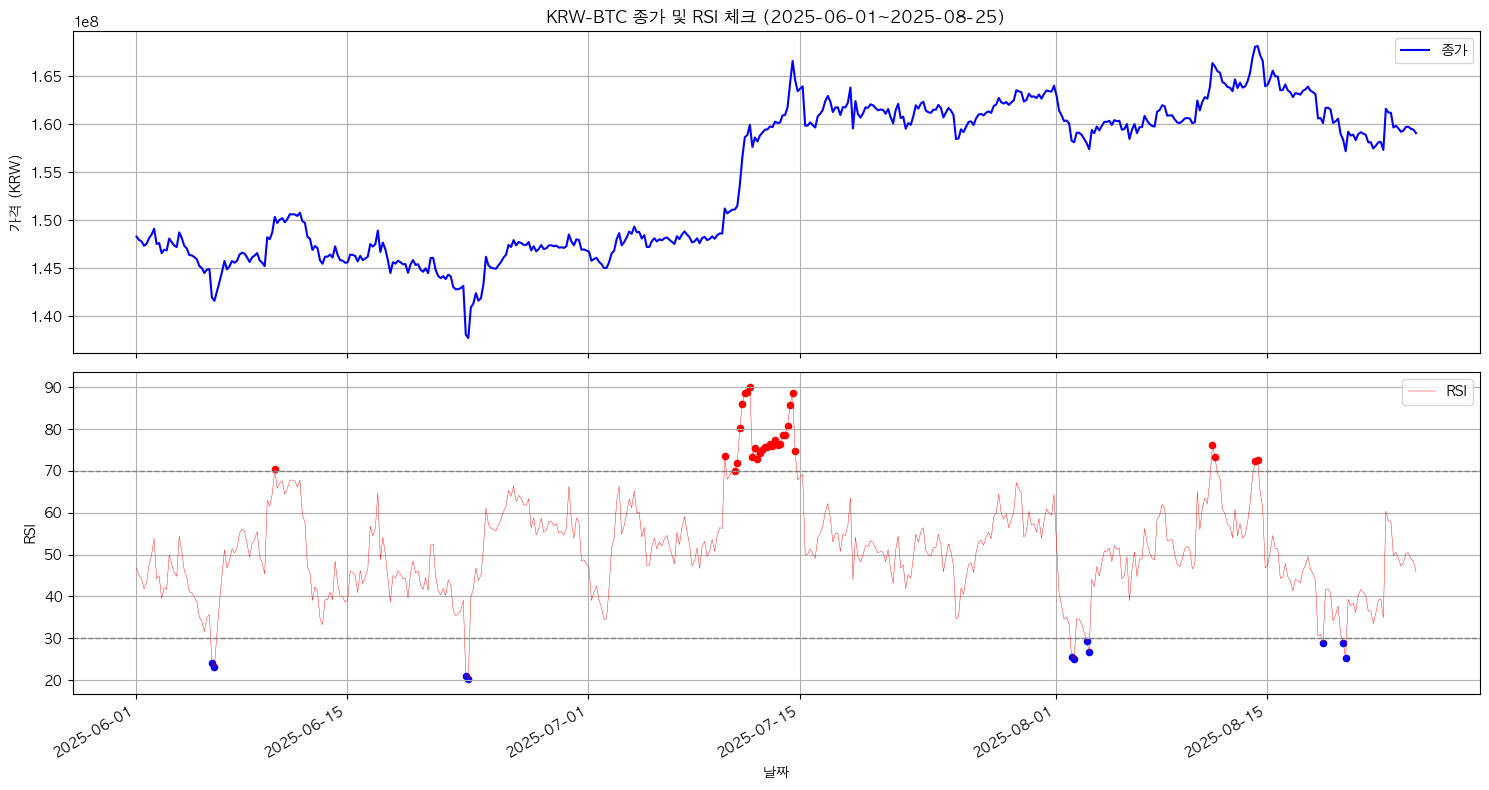


============== RSI 배타스트 결과 ==============
통계 기간: 2025-06-01 ~ 2025-08-25
초기 자본: 1,000,000원
참적 자산: 1,204,380원
수익률: 20.44%
============== 거래 내역 ==============
[2025-06-06 01:00] 🟦 매수 | 가격: 141,928,000 | 수량: 0.001408 | 총 매수가격: 200,000 | 남은 자본: 800,000원
[2025-06-06 01:30] 🟦 매수 | 가격: 141,928,000 | 수량: 0.001127 | 총 매수가격: 160,000 | 남은 자본: 640,000원
[2025-06-06 02:00] 🟦 매수 | 가격: 141,928,000 | 수량: 0.000901 | 총 매수가격: 128,000 | 남은 자본: 512,000원
[2025-06-06 02:30] 🟦 매수 | 가격: 141,928,000 | 수량: 0.000721 | 총 매수가격: 102,400 | 남은 자본: 409,600원
[2025-06-06 03:00] 🟦 매수 | 가격: 141,928,000 | 수량: 0.000577 | 총 매수가격: 81,920 | 남은 자본: 327,680원
[2025-06-06 03:30] 🟦 매수 | 가격: 141,928,000 | 수량: 0.000462 | 총 매수가격: 65,536 | 남은 자본: 262,144원
[2025-06-06 04:00] 🟦 매수 | 가격: 141,928,000 | 수량: 0.000369 | 총 매수가격: 52,429 | 남은 자본: 209,715원
[2025-06-06 04:30] 🟦 매수 | 가격: 141,928,000 | 수량: 0.000295 | 총 매수가격: 41,943 | 남은 자본: 167,772원
[2025-06-06 05:00] 🟦 매수 | 가격: 141,588,000 | 수량: 0.000237 | 총 매수가격: 33,554 | 남은 자본: 134,218원
[2025-06-0

In [7]:
import pyupbit                          # 업비트 시세 데이터 API
import matplotlib as mpl               # 포넌 설정 등
import matplotlib.pyplot as plt        # 시각화 라이브러리
import pandas as pd                    # 데이터 처리용
from datetime import datetime, timedelta   # 날짜 계산용
import matplotlib.dates as mdates      # 날짜 포맷 설정용

# 한국 포넌 및 마이너스 깨짝 방지 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

########## 설정 값 ##########
ticker = "KRW-BTC"
start_date = "2025-06-01"
end_date = "2025-08-25"
interval = "minute240"
rsi_period = 14
bot_interval = 30
initial_capital = 1_000_000
min_trade = 5000
fee = 0.0005

####################################### 데이터 수집 #######################################
extra_hours = rsi_period * 2
real_start = pd.to_datetime(start_date) - timedelta(hours=extra_hours)
end_limit = pd.to_datetime(end_date)

to = datetime.now()
all_data = []

while True:
    data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=200)
    if data is None or data.empty:
        break
    all_data.append(data)
    to = data.index[0]
    if to < real_start:
        break

df = pd.concat(all_data)
df = df[~df.index.duplicated(keep='first')]
df = df.sort_index()

######################################## RSI 계산 ########################################
def compute_rsi(data, period=14):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(com=period - 1, min_periods=period).mean()
    ma_down = down.ewm(com=period - 1, min_periods=period).mean()
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["RSI"] = compute_rsi(df["close"], rsi_period)
df = df[(df.index >= pd.to_datetime(start_date)) & (df.index < end_limit)]

###################################### 파리 그래프 ######################################
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df.index, df["close"], label="종가", color='blue')
ax1.set_title(f"{ticker} 종가 및 RSI 체크 ({start_date}~{end_date})")
ax1.set_ylabel("가격 (KRW)")
ax1.grid(True)
ax1.legend()

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(df.index, df["RSI"], label="RSI", color='red', linewidth=0.3)
ax2.axhline(70, color='gray', linestyle='--', linewidth=1)
ax2.axhline(30, color='gray', linestyle='--', linewidth=1)
ax2.set_ylabel("RSI")
ax2.set_xlabel("날짜")
ax2.grid(True)
ax2.legend()

rsi_overbought = df[df["RSI"] >= 70]
ax2.scatter(rsi_overbought.index, rsi_overbought["RSI"], color='red', s=20, label='RSI ≥ 70')
rsi_oversold = df[df["RSI"] <= 30]
ax2.scatter(rsi_oversold.index, rsi_oversold["RSI"], color='blue', s=20, label='RSI ≤ 30')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

###################################### 배타스트 및 결과 ######################################
capital = initial_capital
position = 0
trade_log = []

minutes_per_candle = int(interval.replace("minute", ""))
runs_per_candle = minutes_per_candle // bot_interval

for i in range(1, len(df)):
    rsi = df["RSI"].iloc[i]
    price = df["close"].iloc[i]
    time = df.index[i]

    for j in range(runs_per_candle):
        exec_time = time + timedelta(minutes=bot_interval * j)

        if rsi <= 30 and capital > min_trade:
            invest = capital * 0.2
            if invest >= min_trade:
                qty = (invest * (1 - fee)) / price
                position += qty
                capital -= invest
                trade_log.append((exec_time, "BUY", price, qty, capital))

        elif rsi >= 70 and position > 0:
            proceeds = position * price * (1 - fee)
            capital += proceeds
            trade_log.append((exec_time, "SELL", price, position, capital))
            position = 0

final_value = capital + position * df["close"].iloc[-1]
roi = (final_value - initial_capital) / initial_capital * 100

print("\n============== RSI 배타스트 결과 ==============")
print(f"통계 기간: {start_date} ~ {end_date}")
print(f"초기 자본: {initial_capital:,.0f}원")
print(f"참적 자산: {final_value:,.0f}원")
print(f"수익률: {roi:.2f}%")
print("==============================================")

print("============== 거래 내역 ==============")
avg_price = 0
qty_hold = 0
total_cost = 0

for log in trade_log:
    time, action, price, qty, cash = log

    if action == "BUY":
        cost = price * qty * (1 + fee)
        total_cost += cost
        qty_hold += qty
        avg_price = total_cost / qty_hold
        print(
            f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟦 매수 | "
            f"가격: {price:,.0f} | 수량: {qty:.6f} | 총 매수가격: {cost:,.0f} | 남은 자본: {cash:,.0f}원"
        )

    elif action == "SELL":
        proceeds = price * qty * (1 - fee)
        profit = proceeds - (avg_price * qty)
        print(
            f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟥 매도 | "
            f"가격: {price:,.0f} | 수량: {qty:.6f} | 실현 금액: {proceeds:,.0f} | 남은 자본: {cash:,.0f}원"
        )
        print(
            f"              ➞ 투자 수익: {profit:,.0f}원 (평균 매수가: {avg_price:,.0f})"
        )
        total_cost = 0
        qty_hold = 0
        avg_price = 0

print("========================================\n")


with open("trade_log.txt", "w", encoding="utf-8") as f:
    f.write("============== 거래 내역 ==============\n")
    avg_price = 0
    qty_hold = 0
    total_cost = 0

    for log in trade_log:
        time, action, price, qty, cash = log

        if action == "BUY":
            cost = price * qty * (1 + fee)
            total_cost += cost
            qty_hold += qty
            avg_price = total_cost / qty_hold
            f.write(
                f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟦 매수 | "
                f"가격: {price:,.0f} | 수량: {qty:.6f} | 총 매수가격: {cost:,.0f} | 남은 자본: {cash:,.0f}원\n"
            )

        elif action == "SELL":
            proceeds = price * qty * (1 - fee)
            profit = proceeds - (avg_price * qty)
            f.write(
                f"[{time.strftime('%Y-%m-%d %H:%M')}] 🟥 매도 | "
                f"가격: {price:,.0f} | 수량: {qty:.6f} | 실현 금액: {proceeds:,.0f} | 남은 자본: {cash:,.0f}원\n"
            )
            f.write(
                f"              ➞ 투자 수익: {profit:,.0f}원 (평균 매수가: {avg_price:,.0f})\n"
            )
            total_cost = 0
            qty_hold = 0
            avg_price = 0

    f.write("========================================\n")

